# Identify AR Events Gridded

In [2]:
# %matplotlib ipympl

In [1]:
import ARUtils
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature 

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/castronova/proxy/8787/status,
Dashboard: /user/castronova/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 15.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35707,Workers: 4
Dashboard: /user/castronova/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 15.00 GiB
Comm: tcp://127.0.0.1:34989,Total threads: 1
Dashboard: /user/castronova/proxy/45953/status,Memory: 3.75 GiB
Nanny: tcp://127.0.0.1:40629,


Load data from from Zarr store.

In [3]:
zarr_store = 'gs://cesm2/ivt.zarr'
ds_full = xr.open_zarr(zarr_store, consolidated=False)#, chunks={"time":-1, "lat":"auto", "lon":"auto"})
print(f'Variable size: {ds_full.nbytes/1e9:.1f} GB')

Variable size: 6.5 GB


Select a set of grid cells that cover Bodega Bay, CA (38.3332° N, 123.0481° W)

In [4]:
lat = 38.
lon = -123.125 + 360 
AR_THRESHOLD = 250.
cell_buffer = 10

# the nearest index for the lat/lon provided above
ilon = list(ds_full.lon.values).index(ds_full.sel(lon=lon, method='nearest').lon)
ilat = list(ds_full.lat.values).index(ds_full.sel(lat=lat, method='nearest').lat)

# subset these data to include cells above and below this lat/lon
ds = ds_full.isel(lat=range(ilat-cell_buffer, ilat+cell_buffer),
                  lon=range(ilon-cell_buffer, ilon+cell_buffer)).IVT
ds = ds.to_dataset()

Plot the IVT data for these cells at `time=0` to visualize our domain.

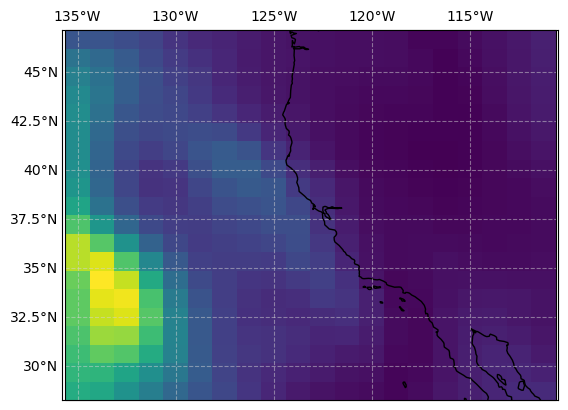

In [5]:
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
ax = plt.axes(projection=ccrs.PlateCarree())

#add coastlines
ax.add_feature(cfeature.COASTLINE)

#add lat lon grids
gl = ax.gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--')
gl.bottom_labels = False
gl.right_labels = False

ds.isel(time=0).IVT.plot(label='',
                         add_labels=False,
                         add_colorbar=False,
                         xticks=None,
                         yticks=None)
plt.show()

## Identify AR Events

In [6]:
# convert the time index to datetime64. This is needed to compute probabilities.
ds['time'] = ds.time.values.astype('datetime64[ns]')  

Assign an index to each group of timesteps that meet AR conditions

In [7]:
ds['AR_INDEX'] = xr.apply_ufunc(
    ARUtils.identify_ar_events,  
    ds.IVT,  
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask='parallelized',
    dask_gufunc_kwargs={'allow_rechunk': True},
)

Compute the duration for each AR event

In [8]:
ds['AR_DURATION'] = xr.apply_ufunc(
    ARUtils.compute_ar_durations,  
    ds.AR_INDEX,  
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask='parallelized',
    dask_gufunc_kwargs={'allow_rechunk': True},
)

Compute the category (1-5) for each AR event

In [9]:
ds['AR_CATEGORY'] = xr.apply_ufunc(
    ARUtils.compute_ar_category,  
    ds.AR_INDEX,
    ds.AR_DURATION,
    ds.IVT,
    input_core_dims=[["time"],["time"],["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask='parallelized',
    dask_gufunc_kwargs={'allow_rechunk': True},
)

Compute the probability of each AR event occurring.

In [10]:
res = xr.apply_ufunc(
    ARUtils.compute_ar_probability,
    ds.AR_INDEX,
    ds.AR_CATEGORY,
    input_core_dims=[["time"],["time"]],
    output_core_dims=[['category']],
    # output_sizes={'category': 5},
    output_dtypes=[float],
    vectorize=True,
    dask='parallelized',
    dask_gufunc_kwargs={'allow_rechunk': True,
                        'output_sizes': {'category': 5}},
)

# Add the category dimension (from 1 to 5)
res = res.assign_coords(category=np.arange(1, 6))

# add the newly computed probabilty back to the original dataset
ds = ds.assign(AR_PROBABILITY=res)

Compute the magnitude of each AR event.

In [11]:
ds['AR_DEGREE'] = xr.apply_ufunc(
    ARUtils.compute_ar_degree,
    ds.IVT,
    ds.AR_DURATION,
    ds.AR_INDEX,
    input_core_dims=[["time"],["time"],["time"]],
    output_core_dims=[['time']],
    output_dtypes=[float],
    vectorize=True,
    dask='parallelized',
    dask_gufunc_kwargs={'allow_rechunk': True},
)

## Plot Computed AR Categories and Degrees

Plot the degree of Category 5 Atmospheric Rivers

In [83]:
# Select a cell of interest
lat = 38.
lon = -123.125 + 360 

# subset the data to include only the cell that matches the
# latitude and longitude defined above.
ds_cell = ds.sel(lat=lat, lon=lon, method='nearest').compute()

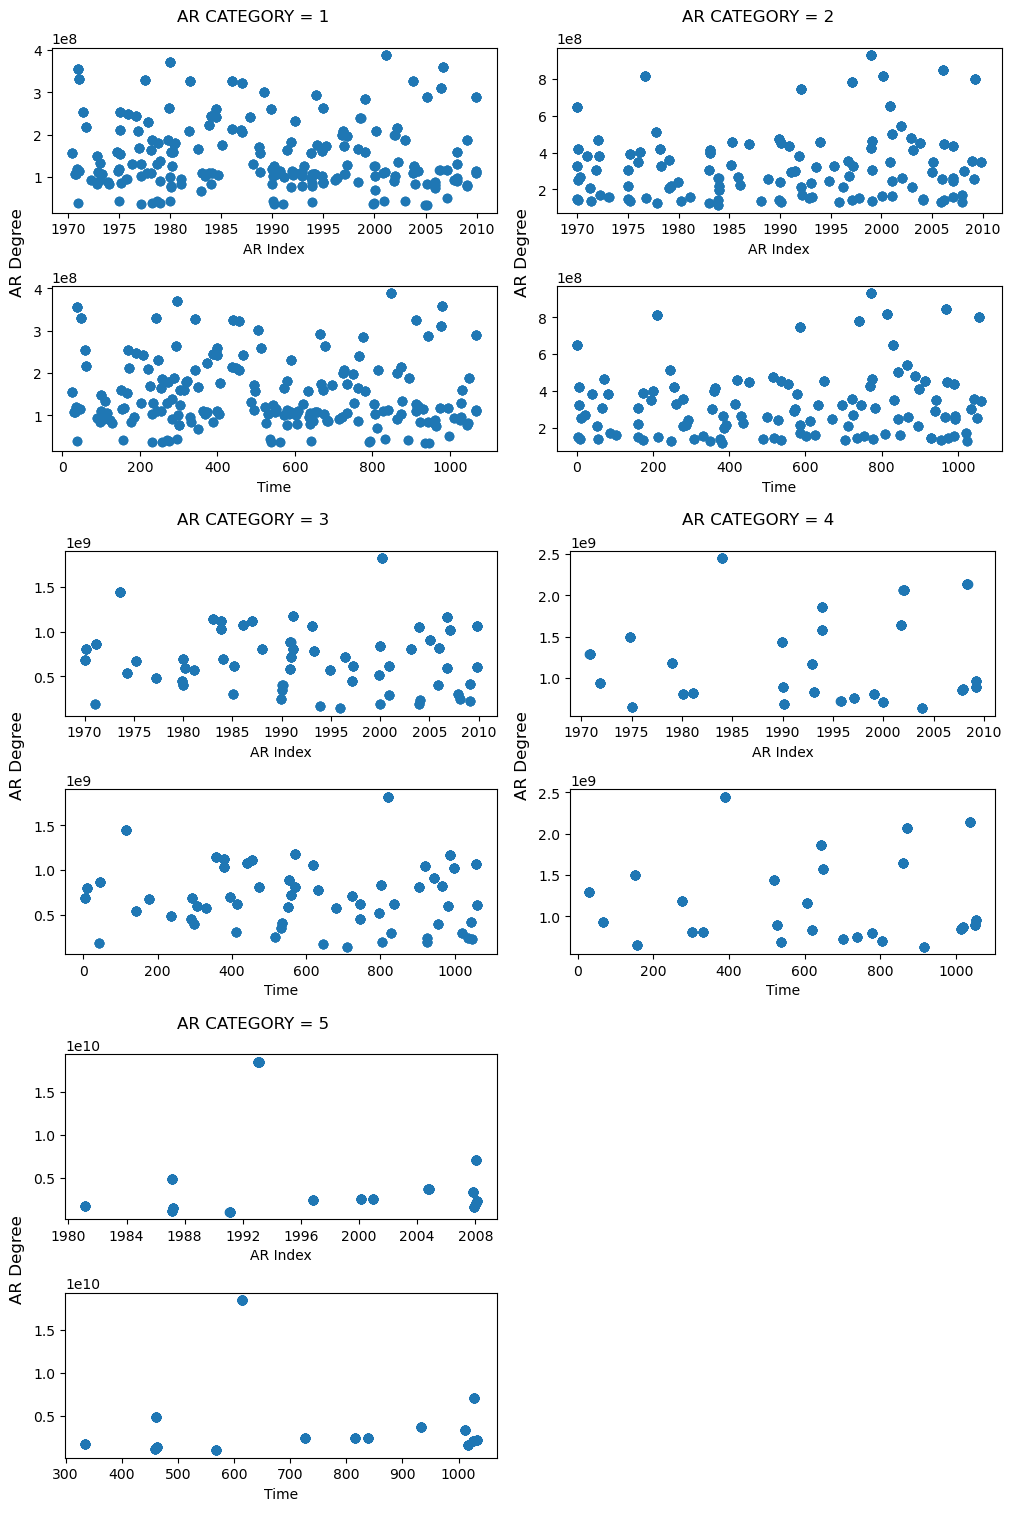

In [123]:
fig = plt.figure(figsize=(10, 15), constrained_layout=True)
subfigs = fig.subfigures(3, 2)

ar_cat = 1
for outer_index, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'AR CATEGORY = {ar_cat}')
    
    axs = subfig.subplots(2, 1)
    ds_cat = ds_cell.where(ds_cell['AR_CATEGORY'] == ar_cat, drop=True)
    axs[0].scatter(x=ds_cat.time, y=ds_cat.AR_DEGREE) 
    axs[0].set_xlabel('AR Index')
    
    axs[1].scatter(x=ds_cat.AR_INDEX, y=ds_cat.AR_DEGREE) 
    axs[1].set_xlabel('Time')

    subfig.supylabel('AR Degree')

    ar_cat += 1

    if ar_cat > 5:
        break
 
plt.show()


Spatially plot the probability of Category 5 Atmospheric Rivers

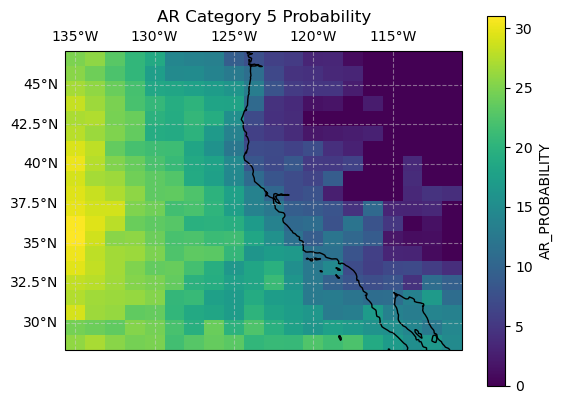

In [190]:
fig, ax = plt.subplots()

ax.axis('off')

ax = plt.axes(projection=ccrs.PlateCarree())

#add coastlines
ax.add_feature(cfeature.COASTLINE)

#add lat lon grids
gl = ax.gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--')
gl.bottom_labels = False
gl.right_labels = False

ds.AR_PROBABILITY.sel(category=5).plot()

plt.title('AR Category 5 Probability')
plt.show()



Plot Atmospheric Rivers category at a single point in time.

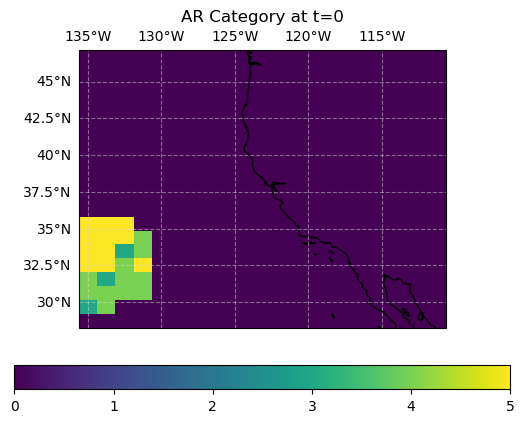

In [125]:
fig, ax = plt.subplots()
ax.axis('off')

ax = plt.axes(projection=ccrs.PlateCarree())

#add coastlines
ax.add_feature(cfeature.COASTLINE)

#add lat lon grids
gl = ax.gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--')
gl.bottom_labels = False
gl.right_labels = False

ds.isel(time=0).AR_CATEGORY.plot(label='',
                                 add_labels=False,
                                 add_colorbar=True,
                                 xticks=None,
                                 yticks=None,
                                 cbar_kwargs={"location": "bottom", "pad":0.1})

plt.title('AR Category at t=0')
plt.show()

Mean Atmospheric Rivers category through the record of data.

In [132]:
# compute the mean category for each grid cell
ds_mean_cat = ds.where(ds.AR_CATEGORY > 0).AR_CATEGORY.mean(dim='time').compute()

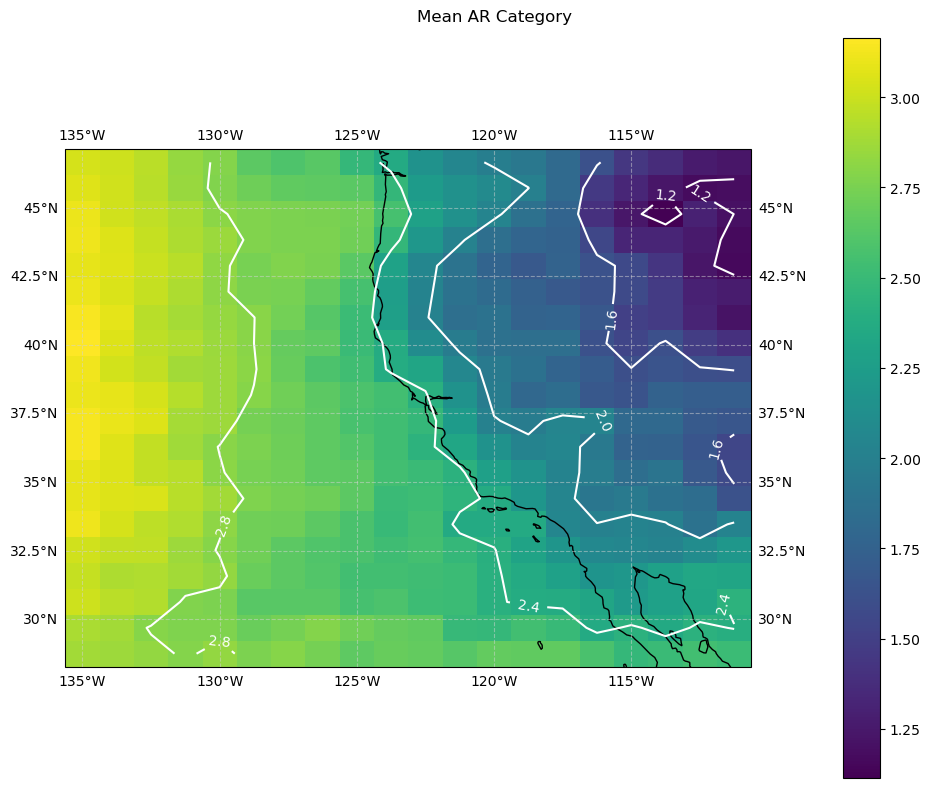

In [136]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,8))

# add coastlines and lat/lon grid for reference
ax.coastlines();
ax.gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--');

# created grid and contour plots.
ds_mean_cat.plot(label='',
                 add_labels=False,
                 add_colorbar=True,
                 cbar_kwargs={"location": "right", "pad":0.1},
                 ax=ax)

cplot = ds_mean_cat.plot.contour(add_labels=True,
                         add_colorbar=False,
                         colors='white',
                         ax=ax)
ax.clabel(cplot)

fig.suptitle('Mean AR Category')
plt.tight_layout()
plt.show()

Build contour plots of mean AR_CATEGORY for each decade in our dataset.

In [137]:
year = ds["time"].dt.year
decade = np.floor(year / 10) * 10
ds = ds.assign_coords({'decade':decade})

In [138]:
ds_decade = ds.where(ds.AR_CATEGORY > 0) \
            .AR_CATEGORY \
            .groupby('decade') \
            .mean(dim='time').compute()

Text(0.5, 0.98, 'Mean Decadal AR Category')

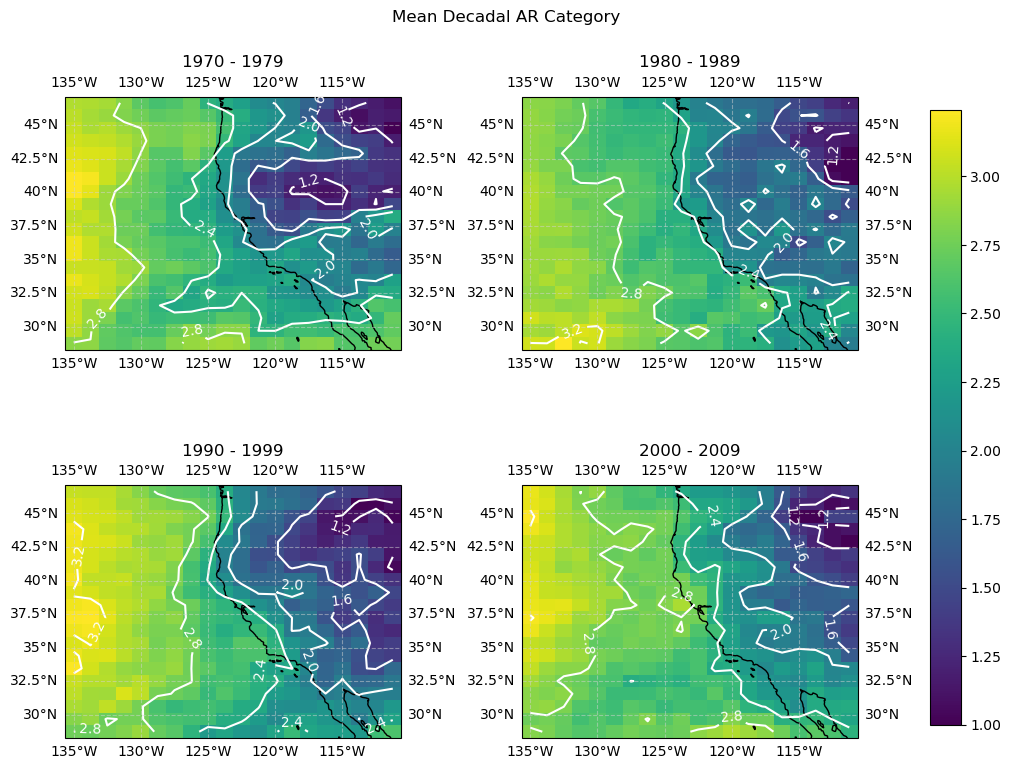

In [152]:
fig, ax = plt.subplots(nrows=2, ncols=2,
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,8),
                       layout='constrained')

axes = ax.flatten()
for i in range(0, len(ds_decade.decade)):
    axes[i].coastlines();
    axes[i].gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--');
    
    # created grid and contour plots.
    d_plot = ds_decade.isel(decade=i).plot(label='',
                   add_labels=False,
                   add_colorbar=False,                   
                   ax=axes[i])
    
    c_plot = ds_decade.isel(decade=i).plot.contour(add_labels=True,
                                                   add_colorbar=False,
                                                   colors='white',
                                                   ax=axes[i])
    axes[i].clabel(c_plot)


    st = int(ds_decade.decade[i].item())
    et = st + 9
    axes[i].set_title(f'{st} - {et}')

fig.colorbar(d_plot, ax=ax[:, 1], shrink=0.8);
fig.suptitle('Mean Decadal AR Category');

Build contour plots of mean AR_DEGREE for each decade in our dataset.

In [153]:
ds_decade = ds.where(ds.AR_CATEGORY > 0) \
            .AR_DEGREE \
            .groupby('decade') \
            .mean(dim='time').compute()

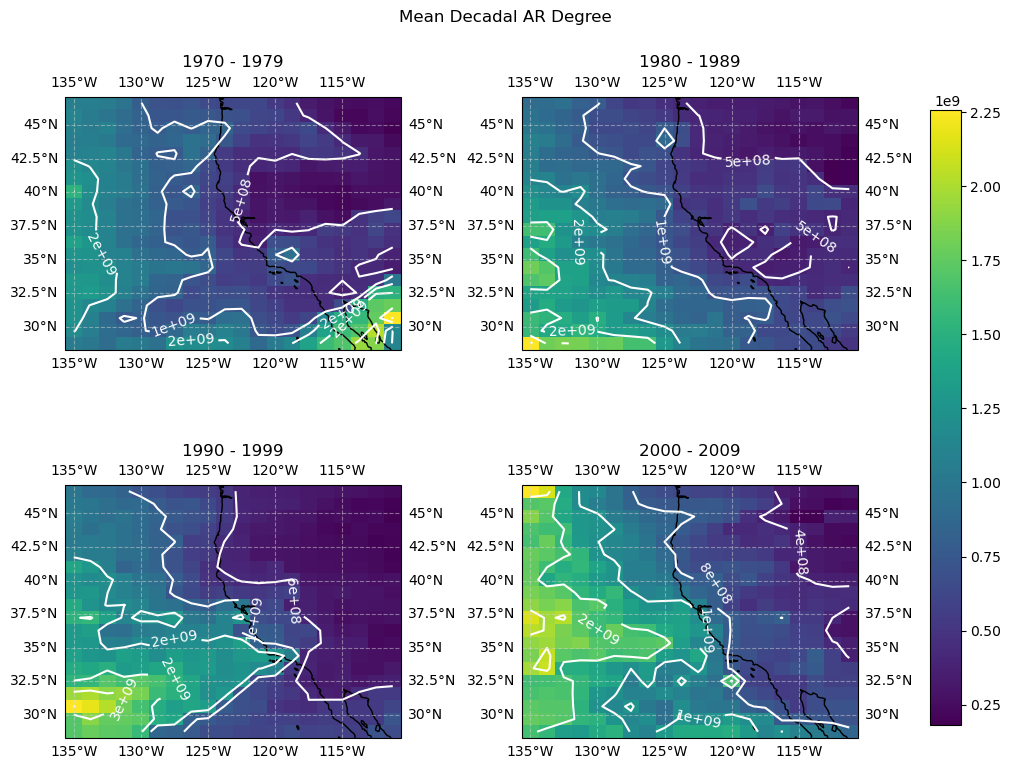

In [189]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(nrows=2, ncols=2,
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,8),
                       layout='constrained')

axes = ax.flatten()
for i in range(0, len(ds_decade.decade)):
    axes[i].coastlines();
    axes[i].gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--');
    
    # created grid and contour plots.
    d_plot = ds_decade.isel(decade=i).plot(label='',
                   add_labels=False,
                   add_colorbar=False,                   
                   ax=axes[i])
    
    c_plot = ds_decade.isel(decade=i).plot.contour(add_labels=True,
                                                   add_colorbar=False,
                                                   colors='white',
                                                   ax=axes[i])
    fmt = ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((0, 0))
    fmt.create_dummy_axis()    
    
    def fmt_func(value):
        return f'{value:.0e}'
        
        
    axes[i].clabel(c_plot, inline=True, fontsize=10, fmt=fmt_func)


    st = int(ds_decade.decade[i].item())
    et = st + 9
    axes[i].set_title(f'{st} - {et}')

fig.colorbar(d_plot, ax=ax[:, 1], shrink=0.8);
fig.suptitle('Mean Decadal AR Degree');